In [312]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from hd_extension import *

In [313]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac_csvs"
brain_region = '#15616F'

In [314]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n7-240821-114717/Notes.txt
read from t=0s to t=1309.86s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n2-240507-093913/Notes.txt
read from t=0s to t=1511.09s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n6-240821-100116/Notes.txt
read from t=0s to t=1335.06s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n1-240507-080133/Notes.txt
read from t=0s to t=1573.39s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n3-240507-115440/Notes.txt
read from t=0s to t=1494.38s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/C1_2_Hab_Dishab/nac/n5-240821-085040/Notes.txt
read from t=0s to t=1324.06s
Found Synapse note file: /Users/naylajim

In [315]:
bout_definitions = [
    {'prefix': 's1', 'introduced': 's1_Introduced', 'removed': 's1_Removed'},
    {'prefix': 's2', 'introduced': 's2_Introduced', 'removed': 's2_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for n7-240821-114717...
Processing behaviors for n2-240507-093913...
Processing behaviors for n6-240821-100116...
Processing behaviors for n1-240507-080133...
Processing behaviors for n3-240507-115440...
Processing behaviors for n5-240821-085040...
Processing behaviors for n4-240507-140651...


Total Investigation Time & Average Bout Duration

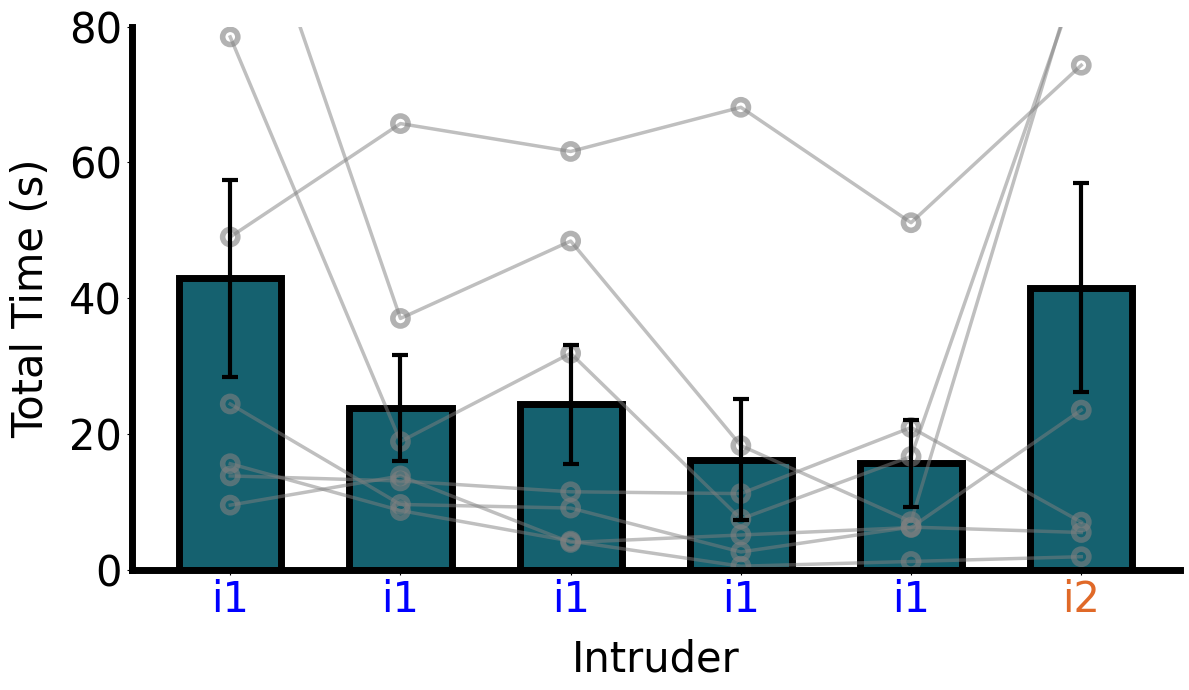

In [316]:
nn1 = experiment.trials['n1-240507-080133']
nn2 = experiment.trials['n2-240507-093913']
nn3 = experiment.trials['n3-240507-115440']
nn4 = experiment.trials['n4-240507-140651']
nn5 = experiment.trials['n5-240821-085040']
nn6 = experiment.trials['n6-240821-100116']
nn7 = experiment.trials['n7-240821-114717']
#nn8 = experiment.trials['p8-240821-121933']

# Read each CSV into a DataFrame
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors
#df8 = nn8.behaviors

# Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)

# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Approach', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Approach', min_duration=0.5)
    
# --- Filter Summary DataFrame by Specific Bouts ---
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# get rid of 5
# filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# Group by Subject and Bout and sum Duration (s) to ensure unique pairs
grouped_df = filtered_summary_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()

# Pivot the grouped DataFrame so that rows are subjects and columns are bouts
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # Fill missing values with 0

# Then call your plotting function
plot_y_across_bouts_gray(
    df=pivot_df,
    title=None,
    ylabel="Total Time (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 80),
    bar_color=brain_region,
    yticks_increment=20,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

Dopamine Analysis

In [340]:
experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    peak_fall_fraction=0.6,    # Set the fall threshold to 60% of the peak
    allow_bout_extension=True, # Allow extending the bout window if needed
    first=True                 # Consider only the first investigation event per bout
)

Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...


In [342]:
# Access behaviors DataFrame for a specific trial
trial_name = "n1-240507-080133"  # Replace with a valid trial name
if trial_name in experiment.trials:
    print(experiment.trials[trial_name].behaviors)


Empty DataFrame
Columns: [Bout, Behavior, Event_Start, Event_End, Duration (s)]
Index: []


In [ ]:
def get_updated_da_metrics(experiment, metric_names=None):
    """
    Retrieves and prints the updated DA metrics for all trials in the experiment.

    Parameters:
        - experiment: The experiment object containing trials with computed DA metrics.
        - metric_names (list of str): The specific DA metrics to retrieve 
                                      (e.g., ["Mean Z-score", "AUC"]).
                                      If None, defaults to ["AUC", "Max Peak", 
                                      "Time of Max Peak", "Mean Z-score"].

    Returns:
        - metrics_df (pd.DataFrame): A combined DataFrame containing the DA metrics across all trials.
    """
    
    if metric_names is None:
        metric_names = ["AUC", "Max Peak", "Time of Max Peak", "Mean Z-score"]  # Default metrics
    
    trial_data = []

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and isinstance(trial.behaviors, pd.DataFrame) and not trial.behaviors.empty:
            # Extract relevant metrics from behaviors DataFrame
            missing_metrics = [m for m in metric_names if m not in trial.behaviors.columns]
            if not missing_metrics:
                df = trial.behaviors[["Bout"] + metric_names].copy()
                df["Trial"] = trial_name  # Add trial identifier
                trial_data.append(df)
            else:
                print(f"Warning: Trial '{trial_name}' is missing metrics: {missing_metrics}. Skipping.")

        else:
            print(f"Warning: Trial '{trial_name}' has no valid behavior data. Skipping.")

    if not trial_data:
        print("No computed DA metrics available to display.")
        return None

    # Combine all trial data into a single DataFrame
    metrics_df = pd.concat(trial_data, ignore_index=True)

    # Print the first few rows for quick inspection
    print(metrics_df.head())

    return metrics_df  # Return DataFrame for further use if needed

# Call the function to retrieve and display the updated DA metrics
updated_metrics_df = get_updated_da_metrics(experiment)

No computed DA metrics available to display.


In [321]:
def plot_computed_da_metrics(experiment, 
                             metric_name="Mean Z-score", 
                             title="DA Metrics Across Bouts", 
                             ylabel="DA Metric", 
                             xlabel="Bout", 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_color="#00B7D7", 
                             yticks_increment=None, 
                             figsize=(14,8), 
                             pad_inches=0.1):
    """
    Plots the computed DA metrics across bouts for all trials in the experiment.

    Parameters:
        - experiment: The experiment object (with a dictionary attribute `trials`).
        - metric_name (str): The DA metric to plot (e.g., "Mean Z-score").
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - xlabel (str): The label for the x-axis.
        - custom_xtick_labels (list): Custom labels for x-ticks.
        - custom_xtick_colors (list): Colors for x-tick labels.
        - ylim (tuple): Y-axis limits.
        - bar_color (str): Color for bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - figsize (tuple): Figure size.
        - pad_inches (float): Padding around the figure.
    """

    # Collect per-trial data (grouped by Bout for the chosen metric)
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            if metric_name not in df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")

    if not trial_data:
        print("No data available to plot.")
        return

    # Combine all trial data into a single DataFrame.
    combined_df = pd.concat(trial_data, ignore_index=True)

    # Pivot the data for the line plots: rows=Trial, columns=Bout, values=metric_name.
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return
    pivot_df = pivot_df.fillna(0)
    
    # Compute overall average and SEM for each Bout across all trials.
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()

    # Create the figure and a single axis.
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the overall average as a bar chart with error bars.
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual trial lines (all in gray).
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=2.5, marker='o')

    # Set labels and title.
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    if title is not None:
        ax.set_title(title, fontsize=16)

    # Set x-ticks: use custom labels if provided.
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)

    # Increase tick label sizes.
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Set y-limits.
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set y-ticks based on yticks_increment if provided.
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # Remove right and top spines, adjust left and bottom spine width.
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    plt.tight_layout(pad=pad_inches)
    plt.show()

plot_computed_da_metrics(experiment,
    metric_name="Mean Z-score", 
    title="Mean Z-score Across Bouts",
    ylabel="Mean Z-score",
    xlabel="Bout",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 15),
    bar_color="#00B7D7",
    yticks_increment=5,
    figsize=(14,8),
    pad_inches=0.1
)

No data available to plot.


In [322]:
experiment.compute_all_da_metrics(use_fractional=False, max_bout_duration=30, 
                           use_adaptive=False, peak_fall_fraction=0.5, 
                           allow_bout_extension=False,first=False)

Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...


In [323]:
def plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                  metric_name="Mean Z-score", 
                                                  title="Combined DA Metrics", 
                                                  ylabel="DA Metric", 
                                                  xlabel="Bout", 
                                                  custom_xtick_labels=None, 
                                                  custom_xtick_colors=None, 
                                                  ylim=None, 
                                                  bar_color="#00B7D7", 
                                                  yticks_increment=None, 
                                                  figsize=(14,8), 
                                                  pad_inches=0.1):
    """
    Combines two functionalities in one plot:
      1. A bar chart (with error bars for SEM) showing the overall average of the specified DA metric for each bout.
      2. Overlaid line plots (all in gray) for each trial showing the metric across bouts.
    
    The function uses each trial's updated behaviors DataFrame (which now includes computed DA metrics)
    and groups the data by "Bout" to compute one value per trial per bout. Then, it aggregates the data
    across trials to compute the overall average and SEM for each bout.
    
    Parameters:
        - experiment: The experiment object (with a dictionary attribute `trials`).
        - metric_name (str): The DA metric to plot (e.g., "Mean Z-score").
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - xlabel (str): The label for the x-axis.
        - custom_xtick_labels (list): A list of custom x-tick labels. If None, defaults to the Bout names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels. Must be the same length as custom_xtick_labels.
        - ylim (tuple): A tuple (min, max) to set the y-axis limits. If None, limits are set automatically.
        - bar_color (str): The color to use for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - figsize (tuple): Figure size.
        - pad_inches (float): Padding around the figure.
    
    Returns:
        None. Displays the combined plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Collect per-trial data (grouped by Bout for the chosen metric)
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            if metric_name not in df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            # Group by Bout to get one value per Bout (take mean in case of duplicates)
            df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")
    
    if not trial_data:
        print("No data available to plot.")
        return

    # Combine all trial data into a single DataFrame.
    combined_df = pd.concat(trial_data, ignore_index=True)

    # Pivot the data for the line plots: rows=Trial, columns=Bout, values=metric_name.
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return
    pivot_df = pivot_df.fillna(0)
    
    # Compute overall average and SEM for each Bout across all trials.
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()

    # Create the figure and a single axis.
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the overall average as a bar chart with error bars.
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual trial lines (all in gray).
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=2.5, marker='o')
    
    # Set labels and title.
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    if title is not None:
        ax.set_title(title, fontsize=16)
    
    # Set x-ticks: use custom labels if provided.
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)
    
    # Increase tick label sizes.
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    
    # Set y-limits.
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    
    # Set y-ticks based on yticks_increment if provided.
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)
    
    # Remove right and top spines, adjust left and bottom spine width.
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    
    plt.tight_layout(pad=pad_inches)
    plt.show()

# Compute DA metrics for all trials.
experiment.compute_all_da_metrics(use_fractional=True, 
                                  max_bout_duration=4, 
                                  use_adaptive=False, 
                                  peak_fall_fraction=0.5, 
                                  allow_bout_extension=False, 
                                  first=False)

# Now plot the combined DA metric (Mean Z-score) using the integrated function.
plot_da_metrics_combined_oneplot_integrated(
    experiment, 
    metric_name="Mean Z-score", 
    title="Mean Z-score Across Bouts (Combined)",
    ylabel="Mean Z-score",
    xlabel="Bout",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 15),
    bar_color=brain_region,
    yticks_increment=5,
    figsize=(14,8),
    pad_inches=0.1
)

Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...
No data available to plot.


In [324]:
experiment.compute_all_da_metrics(use_fractional=True, 
                                  max_bout_duration=4, 
                                  use_adaptive=False, 
                                  peak_fall_fraction=0.5, 
                                  allow_bout_extension=False, 
                                  first=True)


for trial_name, trial in experiment.trials.items():
    print(f"{trial_name} behaviors AFTER DA computation:\n", trial.behaviors.head())



Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...
n7-240821-114717 behaviors AFTER DA computation:
 Empty DataFrame
Columns: [Bout, Behavior, Event_Start, Event_End, Duration (s)]
Index: []
n2-240507-093913 behaviors AFTER DA computation:
 Empty DataFrame
Columns: [Bout, Behavior, Event_Start, Event_End, Duration (s)]
Index: []
n6-240821-100116 behaviors AFTER DA computation:
 Empty DataFrame
Columns: [Bout, Behavior, Event_Start, Event_End, Duration (s)]
Index: []
n1-240507-080133 behaviors AFTER DA computation:
 Empty DataFrame
Columns: [Bout, Behavior, Event_Start, Event_End, Duration (s)]
Index: []
n3-240507-115440 behaviors AFTER DA computation:
 Empty DataFrame
Columns: [Bout, Behavior, Event_Start, Event_End, Du

In [325]:
# this plots every individual mouse mean z-score da as a color
def plot_computed_da_metrics(experiment, 
                             metric_name="DA_peak", 
                             title="Computed DA Metrics Across Trials", 
                             ylabel="DA Metric", 
                             xlabel="Bout", 
                             figsize=(12,8)):
    """
    Plots the specified DA metric across all trials in the experiment.
    
    Assumes that after compute_all_da_metrics is run, each trial in experiment.trials
    has its behaviors DataFrame updated with the computed DA metrics. This function groups
    the data by 'Bout' (averaging the specified metric if there are duplicates), pivots the data 
    so that each row corresponds to a trial and each column corresponds to a Bout, and then 
    plots the chosen metric.
    
    Parameters:
        - experiment: The experiment object (which has a dictionary attribute `trials`).
        - metric_name (str): The DA metric column to plot (e.g., "DA_peak", "AUC", etc.).
        - title (str): The title of the plot.
        - ylabel (str): The y-axis label.
        - xlabel (str): The x-axis label.
        - figsize (tuple): The size of the figure.
    
    Returns:
        None. Displays a plot with one line per trial.
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    all_metrics = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            if metric_name not in df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            # Group only the metric column by Bout to get one numeric value per Bout.
            df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name  # add trial identifier
            all_metrics.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")
    
    if not all_metrics:
        print("No computed DA metrics available to plot.")
        return
    
    # Combine all trial data into a single DataFrame and pivot it.
    metrics_df = pd.concat(all_metrics, ignore_index=True)
    try:
        pivot_df = metrics_df.pivot(index="Trial", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting DA metrics DataFrame:", e)
        return

    pivot_df = pivot_df.fillna(0)  # Replace missing values with 0

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], marker="o", label=trial)
    
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.legend(title="Trial", fontsize=10, title_fontsize=12)
    
    plt.tight_layout()
    plt.show()
# Compute DA metrics for all trials.
experiment.compute_all_da_metrics(use_fractional=False, 
                                  max_bout_duration=30, 
                                  use_adaptive=False, 
                                  peak_fall_fraction=0.5, 
                                  allow_bout_extension=False, 
                                  first=False)

# Plot the computed DA metric using "Mean Z-score"
plot_computed_da_metrics(experiment, 
                         metric_name="Mean Z-score", 
                         title="Mean Z-score Across Bouts",
                         ylabel="Mean Z-score",
                         xlabel="Bout",
                         figsize=(14,8))


Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...
No computed DA metrics available to plot.


In [326]:
def plot_average_metric_histogram(experiment, 
                                  metric_name="Mean Z-score", 
                                  title="Average Metric Across Bouts", 
                                  ylabel="Average Metric", 
                                  xlabel="Bout", 
                                  figsize=(12,8)):
    """
    Computes the average of the specified metric across all trials for each bout and
    plots the results as a bar chart.
    
    Assumes that each trial in experiment.trials has its updated behaviors DataFrame 
    (with computed DA metrics) containing the specified metric and a "Bout" column.
    
    Parameters:
        - experiment: The experiment object (which has a dictionary attribute `trials`).
        - metric_name (str): The name of the metric to average (e.g., "Mean Z-score").
        - title (str): The title for the plot.
        - ylabel (str): The y-axis label.
        - xlabel (str): The x-axis label.
        - figsize (tuple): The figure size.
    
    Returns:
        None. Displays a bar chart with bout labels on the x-axis and the average metric on the y-axis.
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # Collect the metric data from each trial.
    all_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            if metric_name in df.columns:
                # Group by Bout within this trial and compute the mean metric value.
                df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
                df_grouped["Trial"] = trial_name  # tag the trial
                all_data.append(df_grouped)
            else:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'.")
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")

    if not all_data:
        print("No metric data available to plot.")
        return

    # Combine all trial data into one DataFrame.
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Now, group by Bout across all trials and compute the overall average of the metric.
    avg_by_bout = combined_df.groupby("Bout", as_index=False)[metric_name].mean()

    # Create the bar chart.
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(avg_by_bout["Bout"], avg_by_bout[metric_name], color="skyblue", edgecolor="black")
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    
    plt.tight_layout()
    plt.show()

# Compute DA metrics for all trials.
experiment.compute_all_da_metrics(use_fractional=False, 
                                  max_bout_duration=30, 
                                  use_adaptive=False, 
                                  peak_fall_fraction=0.5, 
                                  allow_bout_extension=False, 
                                  first=False)

# Plot the average "Mean Z-score" across bouts
plot_average_metric_histogram(experiment, 
                              metric_name="Mean Z-score", 
                              title="Average Mean Z-score Across Bouts",
                              ylabel="Mean Z-score",
                              xlabel="Bout",
                              figsize=(12,8))

Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...
No metric data available to plot.


In [327]:
def plot_da_metrics_combined_oneplot(experiment, 
                                     metric_name="Mean Z-score", 
                                     title="Combined DA Metrics", 
                                     ylabel="DA Metric", 
                                     xlabel="Bout", 
                                     figsize=(14,8)):
    """
    Plots a combined figure with:
      - A bar chart showing the overall average of the specified DA metric for each bout.
      - Overlaid line plots for each trial (each in a unique color) showing the chosen metric across bouts.
    
    This function assumes that each trial in experiment.trials has its updated behaviors DataFrame 
    (with computed DA metrics) containing at least:
        - 'Bout': Bout label (e.g., "s1-1", "s2-1", etc.)
        - A column corresponding to the desired DA metric (e.g., "Mean Z-score").
    
    Parameters:
        - experiment: The experiment object (with a dictionary attribute `trials`).
        - metric_name (str): The DA metric to plot (e.g., "Mean Z-score").
        - title (str): The title for the plot.
        - ylabel (str): The y-axis label.
        - xlabel (str): The x-axis label.
        - figsize (tuple): The size of the figure.
    
    Returns:
        None. Displays a single plot that combines the overall average (bar chart)
        and the individual trial lines.
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Collect per-trial data from updated behaviors.
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            if metric_name not in df.columns:
                print(f"Warning: Trial '{trial_name}' does not have '{metric_name}'. Skipping.")
                continue
            # Group by Bout to get one numeric value per Bout for this trial.
            df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")
    
    if not trial_data:
        print("No data available to plot.")
        return
    
    # Combine data from all trials.
    combined_df = pd.concat(trial_data, ignore_index=True)
    
    # Pivot the combined DataFrame for the line plot: rows = Trial, columns = Bout.
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting data:", e)
        return
    pivot_df = pivot_df.fillna(0)
    
    # Compute overall average for each Bout across all trials.
    overall_avg = combined_df.groupby("Bout", as_index=False)[metric_name].mean()
    
    # Create a single figure and axis.
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the overall average as a bar chart (with semi-transparent bars).
    ax.bar(overall_avg["Bout"], overall_avg[metric_name], color="skyblue", edgecolor="black", 
           alpha=0.5, label="Overall Average")
    
    # Plot each trial's data as a line plot.
    cmap = plt.cm.get_cmap("tab10", len(pivot_df.index))
    for i, trial in enumerate(pivot_df.index):
        ax.plot(pivot_df.columns, pivot_df.loc[trial], marker="o", color=cmap(i), label=trial)
    
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.legend(title="Trial", fontsize=10, title_fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Compute DA metrics for all trials.
experiment.compute_all_da_metrics(use_fractional=False, 
                                  max_bout_duration=30, 
                                  use_adaptive=False, 
                                  peak_fall_fraction=0.5, 
                                  allow_bout_extension=False, 
                                  first=False)

# Now plot the combined metrics (using "Mean Z-score" as the metric).
plot_da_metrics_combined_oneplot(experiment, 
                                 metric_name="Mean Z-score", 
                                 title="Mean Z-score Across Bouts (Combined)",
                                 ylabel="Mean Z-score",
                                 xlabel="Bout",
                                 figsize=(14,8))

Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...
No data available to plot.


In [328]:
def plot_da_metrics_combined_oneplot(experiment, 
                                     metric_name="Mean Z-score", 
                                     title="Combined DA Metrics", 
                                     ylabel="DA Metric", 
                                     xlabel="Bout", 
                                     figsize=(14,8)):
    """
    Plots a combined figure with:
      - A bar chart showing the overall average of the specified DA metric for each bout.
      - Overlaid line plots for each trial (all lines in gray) showing the chosen metric across bouts.
    
    This function assumes that each trial in experiment.trials has its updated behaviors DataFrame 
    (with computed DA metrics) containing at least:
        - 'Bout': Bout label (e.g., "s1-1", "s2-1", etc.)
        - A column corresponding to the desired DA metric (e.g., "Mean Z-score").
    
    Parameters:
        - experiment: The experiment object (with a dictionary attribute `trials`).
        - metric_name (str): The DA metric to plot (e.g., "Mean Z-score").
        - title (str): The title for the plot.
        - ylabel (str): The y-axis label.
        - xlabel (str): The x-axis label.
        - figsize (tuple): The size of the figure.
    
    Returns:
        None. Displays a single plot that combines the overall average (bar chart)
        and the individual trial lines (in gray).
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    # Collect per-trial data from updated behaviors.
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            if metric_name not in df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            # Group by Bout to get one numeric value per Bout for this trial.
            df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")
    
    if not trial_data:
        print("No data available to plot.")
        return
    
    # Combine data from all trials.
    combined_df = pd.concat(trial_data, ignore_index=True)
    
    # Pivot the combined DataFrame for the line plot: rows = Trial, columns = Bout.
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting data:", e)
        return
    pivot_df = pivot_df.fillna(0)
    
    # Compute overall average for each Bout across all trials.
    overall_avg = combined_df.groupby("Bout", as_index=False)[metric_name].mean()
    
    # Create a single figure and axis.
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the overall average as a bar chart (with semi-transparent bars).
    ax.bar(overall_avg["Bout"], overall_avg[metric_name], color="skyblue", edgecolor="black", 
           alpha=0.5, label="Overall Average")
    
    # Plot each trial's data as a line plot (all in gray).
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], marker="o", color="gray", label=trial)
    
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.legend(title="Trial", fontsize=10, title_fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Compute DA metrics for all trials.
experiment.compute_all_da_metrics(use_fractional=False, 
                                  max_bout_duration=30, 
                                  use_adaptive=False, 
                                  peak_fall_fraction=0.5, 
                                  allow_bout_extension=False, 
                                  first=False)

# Now plot the combined metrics using "Mean Z-score" as the metric.
plot_da_metrics_combined_oneplot(experiment, 
                                 metric_name="Mean Z-score", 
                                 title="Mean Z-score Across Bouts (Combined)",
                                 ylabel="Mean Z-score",
                                 xlabel="Bout",
                                 figsize=(14,8))

Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...
No data available to plot.


In [329]:
def plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                  metric_name="Mean Z-score", 
                                                  title="Combined DA Metrics", 
                                                  ylabel="DA Metric", 
                                                  xlabel="Bout", 
                                                  custom_xtick_labels=None, 
                                                  custom_xtick_colors=None, 
                                                  ylim=None, 
                                                  bar_color="#00B7D7", 
                                                  yticks_increment=None, 
                                                  figsize=(14,8), 
                                                  pad_inches=0.1):
    """
    Combines two functionalities in one plot:
      1. A bar chart (with error bars for SEM) showing the overall average of the specified DA metric for each bout.
      2. Overlaid line plots (all in gray) for each trial showing the metric across bouts.
    
    The function uses each trial's updated behaviors DataFrame (which now includes computed DA metrics)
    and groups the data by "Bout" to compute one value per trial per bout. Then, it aggregates the data
    across trials to compute the overall average and SEM for each bout.
    
    Parameters:
        - experiment: The experiment object (with a dictionary attribute `trials`).
        - metric_name (str): The DA metric to plot (e.g., "Mean Z-score").
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - xlabel (str): The label for the x-axis.
        - custom_xtick_labels (list): A list of custom x-tick labels. If None, defaults to the Bout names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels. Must be the same length as custom_xtick_labels.
        - ylim (tuple): A tuple (min, max) to set the y-axis limits. If None, limits are set automatically.
        - bar_color (str): The color to use for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - figsize (tuple): Figure size.
        - pad_inches (float): Padding around the figure.
    
    Returns:
        None. Displays the combined plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Collect per-trial data (grouped by Bout for the chosen metric)
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            if metric_name not in df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            # Group by Bout to get one value per Bout (take mean in case of duplicates)
            df_grouped = df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")
    
    if not trial_data:
        print("No data available to plot.")
        return

    # Combine all trial data into a single DataFrame.
    combined_df = pd.concat(trial_data, ignore_index=True)

    # Pivot the data for the line plots: rows=Trial, columns=Bout, values=metric_name.
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return
    pivot_df = pivot_df.fillna(0)
    
    # Compute overall average and SEM for each Bout across all trials.
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()

    # Create the figure and a single axis.
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the overall average as a bar chart with error bars.
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual trial lines (all in gray).
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=2.5, marker='o')
    
    # Set labels and title.
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    if title is not None:
        ax.set_title(title, fontsize=16)
    
    # Set x-ticks: use custom labels if provided.
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)
    
    # Increase tick label sizes.
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    
    # Set y-limits.
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    
    # Set y-ticks based on yticks_increment if provided.
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)
    
    # Remove right and top spines, adjust left and bottom spine width.
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    
    plt.tight_layout(pad=pad_inches)
    plt.show()

# Compute DA metrics for all trials.
experiment.compute_all_da_metrics(use_fractional=True, 
                                  max_bout_duration=4, 
                                  use_adaptive=False, 
                                  peak_fall_fraction=0.5, 
                                  allow_bout_extension=False, 
                                  first=False)

# Now plot the combined DA metric (Mean Z-score) using the integrated function.
plot_da_metrics_combined_oneplot_integrated(
    experiment, 
    metric_name="Mean Z-score", 
    title="Mean Z-score Across Bouts (Combined)",
    ylabel="Mean Z-score",
    xlabel="Bout",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 15),
    bar_color=brain_region,
    yticks_increment=5,
    figsize=(14,8),
    pad_inches=0.1
)

Computing DA metrics for n7-240821-114717 ...
Computing DA metrics for n2-240507-093913 ...
Computing DA metrics for n6-240821-100116 ...
Computing DA metrics for n1-240507-080133 ...
Computing DA metrics for n3-240507-115440 ...
Computing DA metrics for n5-240821-085040 ...
Computing DA metrics for n4-240507-140651 ...
No data available to plot.


messin around

/var/folders/tj/nfn3dynx2n19r7566d88xmsc0000gn/T/ipykernel_9646/1917977511.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(df.index))


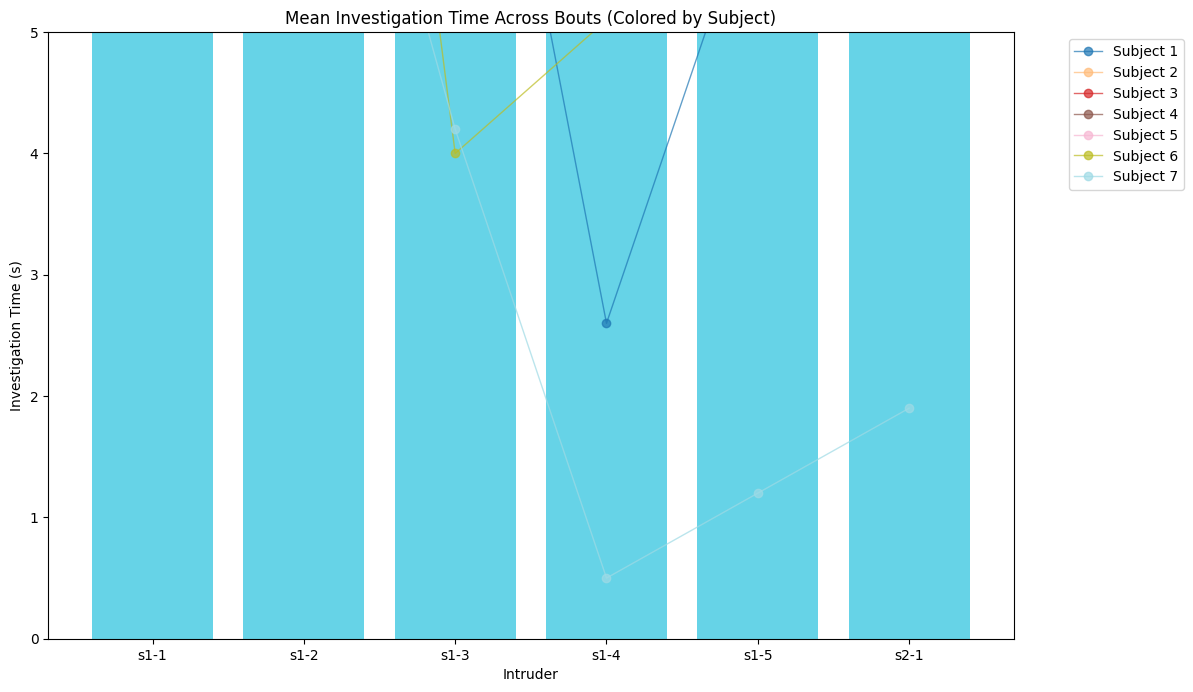

UnboundLocalError: cannot access local variable 'pivot_df' where it is not associated with a value

In [330]:
def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # -------------------------------------------------------
    # Plot each subject's data in a unique color + label
    # -------------------------------------------------------
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        label = f"Subject {idx}"  # <--- ADDED: a label for the legend
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1,
            label=label             # <--- ADDED: pass the label here
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    # -------------------------------------------------------
    # ADDED LEGEND: show the subject labels
    # -------------------------------------------------------
    # You can place the legend in many ways. For example, to the right:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # or simply:
    # ax.legend(loc='best')

    plt.tight_layout(pad=pad_inches)
    plt.show()


# Suppose pivot_df is the DataFrame used in your plot function.
# Fill NaN with 0 for all subjects/bouts.
    pivot_df = pivot_df.fillna(0)

# Now re-plot
hab_dishab_plot_y_across_bouts_colored(
    df=pivot_df,
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 5),
    cmap_name='tab20'
)

Bout      s1-1      s1-2    s1-3      s1-4   s1-5   s2-1
Subject                                                 
1        1.399  1.043667  0.0000  0.000000  0.932  0.000
2        1.177  1.910000  0.9990  1.032500  1.399  0.000
3        1.166  0.749250  0.9655  1.487667  1.999  0.000
4        0.000  1.199000  1.7655  0.999333  0.999  1.733
6        1.599  2.499000  0.0000  2.799000  0.000  2.349


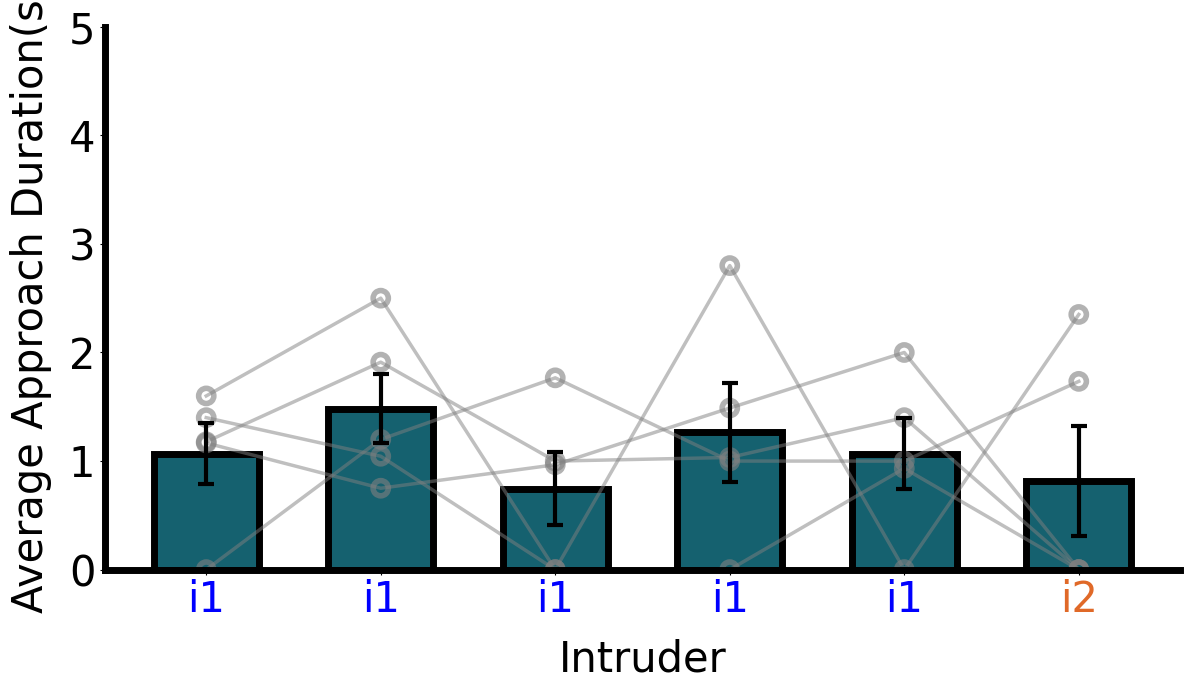

In [ ]:
# Define the desired behavior to include in the analysis
desired_behavior = "Approach"  # Change to "Investigation" if needed

# --- Create combined summary DataFrame (from your trials) ---
summary_df = create_subject_summary_df(trials)

# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Approach events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Approach', bout_time_threshold=1)
    # Remove Approach events shorter than 0.5 seconds.
    nn.remove_short_behaviors(behavior_name='Approach', min_duration=0.5)
    
# --- Filter Summary DataFrame by Specific Bouts ---
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# --- Filter to include only the desired behavior (e.g., Approach) ---
filtered_summary_df = filtered_summary_df[filtered_summary_df["Behavior"] == desired_behavior]

# (Optional) If you want to exclude a particular subject, e.g., Subject 5:
filtered_summary_df = filtered_summary_df[filtered_summary_df["Subject"] != 5]

# --- Group by Subject and Bout and sum Duration (s) to ensure unique pairs ---
grouped_df = filtered_summary_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# --- Pivot the grouped DataFrame so that rows are subjects and columns are bouts ---
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # Fill missing values with 0

# Now, pivot_df is ready to be passed to your plotting function.
print(pivot_df.head())

# Then call your plotting function
plot_y_across_bouts_gray(
    df=pivot_df,
    title=None,
    ylabel="Average Approach Duration(s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 5),
    bar_color=brain_region,
    yticks_increment=1,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)


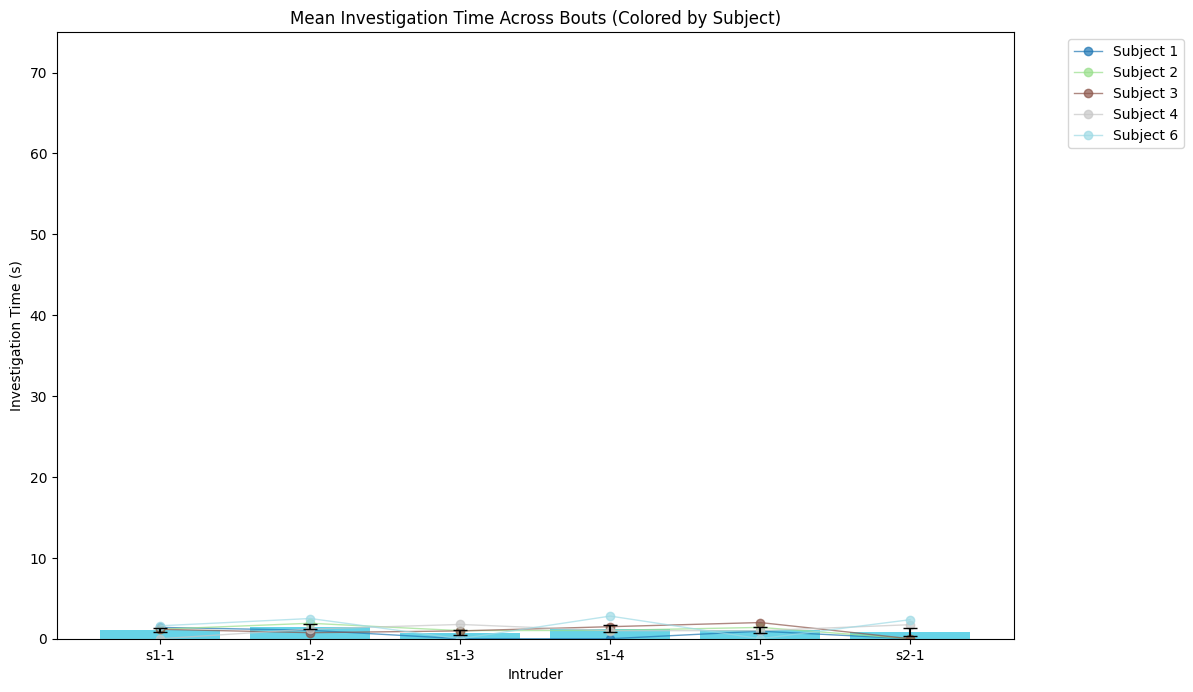

In [ ]:
# Suppose pivot_df is the DataFrame used in your plot function.
# Fill NaN with 0 for all subjects/bouts.
pivot_df = pivot_df.fillna(0)

# Now re-plot
hab_dishab_plot_y_across_bouts_colored(
    df=pivot_df,
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)

In [ ]:
# new code i'm trying
filtered_summary_df = automate_investigation_workflow(
    experiment=experiment,
    trial_keys=["n1-240507-080133", "n2-240507-093913", "n3-240507-115440", 
                "n4-240507-140651", "n5-240821-085040", "n6-240821-100116", "n7-240821-114717"],
    combine_threshold=1,
    min_duration=0.5,
    desired_bouts=["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"],
    calc_method="average"
)
# if you want to omit a subject
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]


grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # Ensure no missing numeric values

plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Bout Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 80),
    bar_color=brain_region,  # make sure brain_region is defined, e.g., brain_region = "#00B7D7"
    yticks_increment=20,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

KeyError: 'Duration (s)'

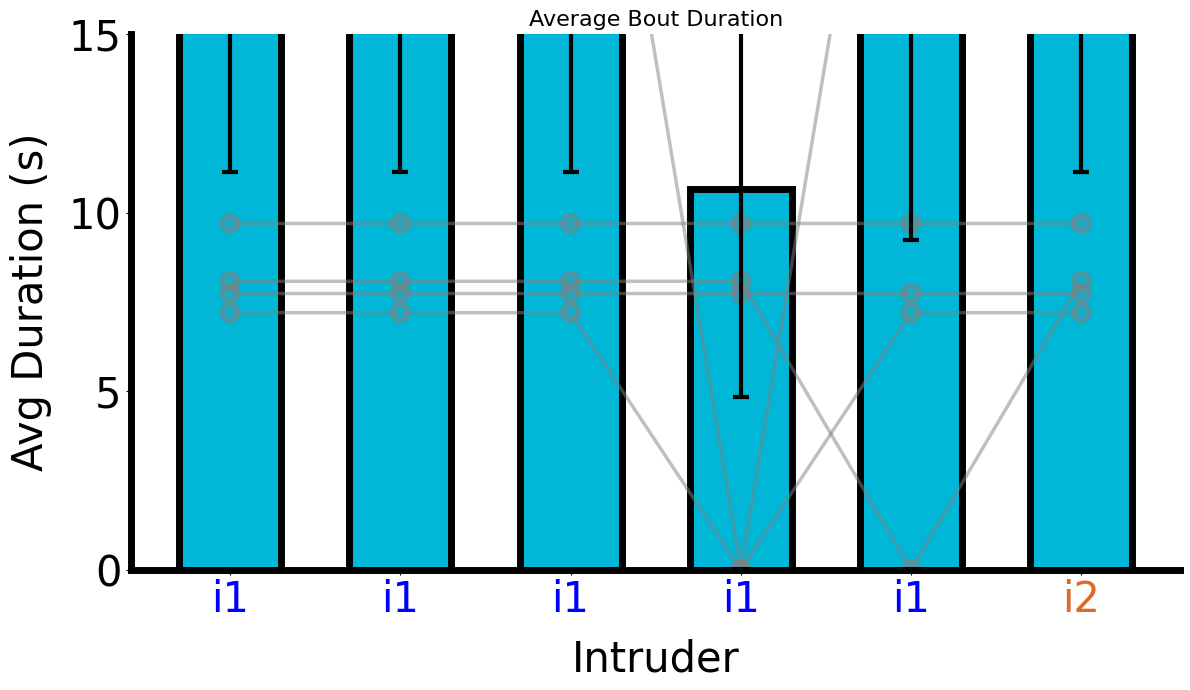

In [ ]:
# 2) Group by (Subject, Bout) and compute the MEAN
grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# 3) Pivot the grouped DataFrame (rows=subjects, cols=bouts, values=mean duration)
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # fill missing with 0 if needed

# 4) Plot using the "Average Bout Duration" label
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 15),    # set an appropriate y-limit if you expect smaller values
    bar_color="#00B7D7",
    yticks_increment=5,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

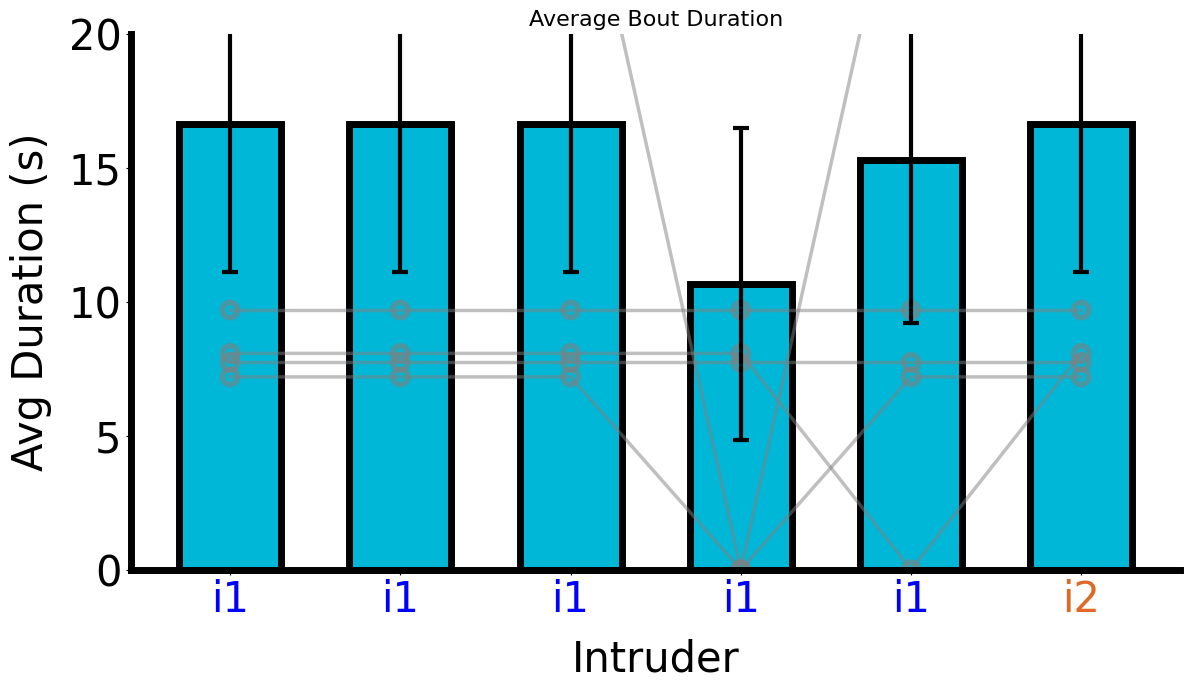

In [ ]:
# 2) Group by (Subject, Bout) and compute the MEAN
grouped_df = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()

# 3) Pivot the grouped DataFrame (rows=subjects, cols=bouts, values=mean duration)
pivot_df = grouped_df.pivot(index="Subject", columns="Bout", values="Duration (s)")
pivot_df = pivot_df.fillna(0)  # fill missing with 0 if needed

# --- Plot the Total Investigation Time Across Bouts for the Filtered Bouts ---
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Average Bout Duration",
    ylabel="Avg Duration (s)",
    custom_xtick_labels=["i1", "i1", "i1", "i1", "i1", "i2"],
    custom_xtick_colors=["blue", "blue", "blue", "blue", "blue", "#E06928"],
    ylim=(0, 20),    # set an appropriate y-limit if you expect smaller values
    bar_color="#00B7D7",
    yticks_increment=5,
    xlabel="Intruder",
    figsize=(12,7),
    pad_inches=0.1
)

In [ ]:
nn1 = experiment.trials['n1-240507-080133']
nn2 = experiment.trials['n2-240507-093913']
nn3 = experiment.trials['n3-240507-115440']
nn4 = experiment.trials['n4-240507-140651']
nn5 = experiment.trials['n5-240821-085040']
nn6 = experiment.trials['n6-240821-100116']
nn7 = experiment.trials['n7-240821-114717']

for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=2)

# Read each CSV into a DataFrame
df1 = nn1.behaviors
df2 = nn2.behaviors
df3 = nn3.behaviors
df4 = nn4.behaviors
df5 = nn5.behaviors
df6 = nn6.behaviors
df7 = nn7.behaviors

# Create a list of the DataFrames
trials = [df1, df2, df3, df4, df5, df6, df7]

# Create one combined summary DataFrame (7 subjects total)
summary_df = create_subject_summary_df(trials)
# --- Behavior Processing for Each Subject ---
for nn in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events that occur within 1 second.
    nn.combine_consecutive_behaviors(behavior_name='Investigation', bout_time_threshold=1)
    # Remove Investigation events shorter than 0.5 seconds (or adjust as needed).
    nn.remove_short_behaviors(behavior_name='Investigation', min_duration=0.5)



# --- Combine Processed Behaviors into a Summary DataFrame ---
trials = [
    nn1.behaviors, nn2.behaviors, nn3.behaviors,
    nn4.behaviors, nn5.behaviors, nn6.behaviors, nn7.behaviors
]


summary_df = create_subject_summary_df(trials)

# --- Filter Summary DataFrame by Specific Bouts ---
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# get rid of 5
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# 1) Remove Subject 5
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]






In [ ]:
# 1) Process each subject's DataFrame (nn1.behaviors, nn2.behaviors, etc.)
processed_dfs = []
for df in [nn1, nn2, nn3, nn4, nn5, nn6, nn7]:
    # Merge consecutive Investigation events within a 5-second threshold
    merged_df = Trial.combine_consecutive_behaviors(
        df, behavior_name='Investigation', bout_time_threshold=5
    )
    # Remove Investigation events shorter than 1 second
    short_removed_df = Trial.remove_short_behaviors(
        merged_df, behavior_name='Investigation', min_duration=1
    )
    processed_dfs.append(short_removed_df)

# 2) Combine the processed DataFrames into a single summary DataFrame
summary_df = create_subject_summary_df(processed_dfs)

# 3) Remove Subject 5 from the summary (i.e., rows where Subject == 5)
summary_df = summary_df[summary_df["Subject"] != 5]

# 4) Filter the summary DataFrame to include only the desired bouts
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

# 5) Plot the total Investigation Time across bouts, y-axis from 0 to 75
plot_behavior_metric(
    df=filtered_summary_df,
    behavior="Investigation",
    metric="investigation_time",  # or "average_bout_duration"
    title="Total Investigation Time Across Selected Bouts (All Subjects, No Subject 5)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75)
)

AttributeError: 'NoneType' object has no attribute 'behaviors'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Standalone Functions for Behavior Processing
# --------------------------
def combine_consecutive_behaviors(df, behavior_name='all', bout_time_threshold=1):
    """
    Combines consecutive behavior events if they occur within the specified time threshold.
    
    Parameters:
      df (DataFrame): Input DataFrame with columns ['Bout', 'Behavior', 'Event_Start', 'Event_End', 'Duration (s)'].
      behavior_name (str): If not 'all', only process rows matching this behavior.
      bout_time_threshold (float): Maximum gap (in seconds) allowed between consecutive events to merge them.
      
    Returns:
      DataFrame with merged events.
    """
    if df.empty:
        return df.copy()
    
    # If processing only a specific behavior, work on that subset
    if behavior_name != 'all':
        working_df = df[df['Behavior'] == behavior_name].copy()
    else:
        working_df = df.copy()
    
    # Sort by Bout, Behavior, and Event_Start to ensure proper merging
    working_df = working_df.sort_values(by=['Bout', 'Behavior', 'Event_Start']).reset_index(drop=True)
    
    combined_rows = []
    # Group by Bout and Behavior to merge events in each group
    for (bout, behavior), group in working_df.groupby(['Bout', 'Behavior']):
        group = group.sort_values('Event_Start').reset_index(drop=True)
        current_start = group.loc[0, 'Event_Start']
        current_end = group.loc[0, 'Event_End']
        
        for i in range(1, len(group)):
            next_start = group.loc[i, 'Event_Start']
            next_end = group.loc[i, 'Event_End']
            
            # If the gap between events is within threshold, merge them
            if next_start - current_end <= bout_time_threshold:
                current_end = next_end  # extend the current event
            else:
                combined_rows.append({
                    'Bout': bout,
                    'Behavior': behavior,
                    'Event_Start': current_start,
                    'Event_End': current_end,
                    'Duration (s)': current_end - current_start
                })
                # Reset to the next event
                current_start = next_start
                current_end = next_end
        
        # Append the last merged event in the group
        combined_rows.append({
            'Bout': bout,
            'Behavior': behavior,
            'Event_Start': current_start,
            'Event_End': current_end,
            'Duration (s)': current_end - current_start
        })
    
    return pd.DataFrame(combined_rows)


def remove_short_behaviors(df, behavior_name='all', min_duration=0):
    """
    Removes events with duration less than min_duration.
    
    Parameters:
      df (DataFrame): Input DataFrame with a 'Duration (s)' column.
      behavior_name (str): If not 'all', only process rows matching this behavior.
      min_duration (float): Minimum duration (in seconds) required to keep an event.
      
    Returns:
      Filtered DataFrame.
    """
    if df.empty:
        return df.copy()
    
    if behavior_name != 'all':
        working_df = df[df['Behavior'] == behavior_name].copy()
    else:
        working_df = df.copy()
    
    working_df = working_df[working_df['Duration (s)'] >= min_duration]
    return working_df.reset_index(drop=True)

# --------------------------
# Functions for Creating Summary & Plotting
# --------------------------
def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each representing one subject's processed behaviors),
    assigns a unique Subject ID (1 to N) to each DataFrame, and computes:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        temp_df["Subject"] = subject_id
        
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1
    
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


def hab_dishab_plot_y_across_bouts_gray(df, 
                                        title='Mean Across Bouts', 
                                        ylabel='Mean Value', 
                                        custom_xtick_labels=None, 
                                        custom_xtick_colors=None, 
                                        ylim=None, 
                                        bar_color='#00B7D7',
                                        yticks_increment=None, 
                                        xlabel='Intruder',
                                        figsize=(12,7), 
                                        pad_inches=1):
    """
    Plots the mean values (with SEM error bars) for each bout, and overlays each subject's data in gray.
    
    Parameters:
      df (DataFrame): rows = subjects, columns = bouts, values = metric to plot.
      title, ylabel, etc.: standard plotting options.
    """
    fig, ax = plt.subplots(figsize=figsize)
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))
    
    # Plot each subject's data in gray
    for idx in df.index:
        ax.plot(x, df.loc[idx, :], color='gray', alpha=0.5, marker='o', linewidth=1)
    
    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)
    
    # Configure x-tick labels and colors if provided
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)
    
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))
    
    plt.tight_layout(pad=pad_inches)
    plt.show()


def plot_behavior_metric(df, 
                         behavior="Investigation", 
                         metric="investigation_time",
                         title='Mean Across Bouts',
                         ylabel='Mean Value',
                         ylim=None):
    """
    Filters the summary DataFrame by a given Behavior, then computes:
      - 'investigation_time': sum of "Duration (s)" per Subject & Bout
      - 'average_bout_duration': mean of "Duration (s)" per Subject & Bout
    Pivots to a subject-by-bout DataFrame and plots with hab_dishab_plot_y_across_bouts_gray.
    """
    filtered_df = df[df["Behavior"] == behavior].copy()
    
    if metric == "investigation_time":
        grouped = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
        plot_label = "Investigation Time (Sum)"
    elif metric == "average_bout_duration":
        grouped = filtered_df.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
        plot_label = "Average Bout Duration (Mean)"
    else:
        raise ValueError("metric must be either 'investigation_time' or 'average_bout_duration'")
    
    pivot_df = grouped.pivot(index="Subject", columns="Bout", values="Duration (s)")
    hab_dishab_plot_y_across_bouts_gray(
        df=pivot_df,
        title=title,
        ylabel=ylabel if ylabel else plot_label,
        ylim=ylim
    )

# --------------------------
# EXAMPLE USAGE
# --------------------------
# Assume you already have DataFrames for each subject's behaviors.
# For example, nn1.behaviors, nn2.behaviors, ... nn7.behaviors have been created elsewhere.
# Each DataFrame should include these columns:
# ['Bout', 'Behavior', 'Event_Start', 'Event_End', 'Duration (s)']

# Process each subject's behaviors (standalone, without classes)
processed_dfs = []
for df in [nn1.behaviors, nn2.behaviors, nn3.behaviors, nn4.behaviors, nn5.behaviors, nn6.behaviors, nn7.behaviors]:
    # Merge consecutive Investigation events within a 1-second threshold.
    merged_df = combine_consecutive_behaviors(df, behavior_name='Investigation', bout_time_threshold=5)
    # Remove Investigation events shorter than 0.5 seconds.
    filtered_df = remove_short_behaviors(merged_df, behavior_name='Investigation', min_duration=1)
    processed_dfs.append(filtered_df)

# Combine the processed DataFrames into a single summary DataFrame.
summary_df = create_subject_summary_df(processed_dfs)

# Filter the summary DataFrame to include only the desired bouts.
desired_bouts = ["s1-1", "s1-2", "s1-3", "s1-4", "s1-5", "s2-1"]
filtered_summary_df = summary_df[summary_df["Bout"].isin(desired_bouts)]

bouts = ['s1_1', 's1_2', 's1_3', 's1_4', 's1_5','s2_1']
custom_xtick_labels = ['i1', 'i1','i1','i1','i1','i2',]
custom_xtick_colors = ['blue', 'blue', 'blue', 'blue', 'blue', '#E06928']

# Plot the total Investigation Time across bouts with the y-axis set from 0 to 60.
plot_behavior_metric(
    df=filtered_summary_df,
    behavior="Investigation",
    metric="investigation_time",  # Alternatively, use "average_bout_duration"
    title="Total Investigation Time Across Selected Bouts (All Subjects)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75)
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_behavior_metric_colored(
    df=filtered_summary_df,  # The full summary DataFrame
    behavior="Investigation",
    metric="investigation_time",
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)

In [ ]:
def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # -------------------------------------------------------
    # Plot each subject's data in a unique color + label
    # -------------------------------------------------------
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        label = f"Subject {idx}"  # <--- ADDED: a label for the legend
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1,
            label=label             # <--- ADDED: pass the label here
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    # -------------------------------------------------------
    # ADDED LEGEND: show the subject labels
    # -------------------------------------------------------
    # You can place the legend in many ways. For example, to the right:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # or simply:
    # ax.legend(loc='best')

    plt.tight_layout(pad=pad_inches)
    plt.show()

# Filter out Subject 5 from the summary DataFrame before pivoting
filtered_df = filtered_summary_df[filtered_summary_df['Subject'] != 5]

# Re-run the analysis and plotting with the filtered data
plot_behavior_metric_colored(
    df=filtered_df,  # Now without Subject 5
    behavior="Investigation",
    metric="investigation_time",
    title="Mean Investigation Time Across Bouts (Colored by Subject, Without Subject 5)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)

/var/folders/tj/nfn3dynx2n19r7566d88xmsc0000gn/T/ipykernel_31048/631157042.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, len(df.index))


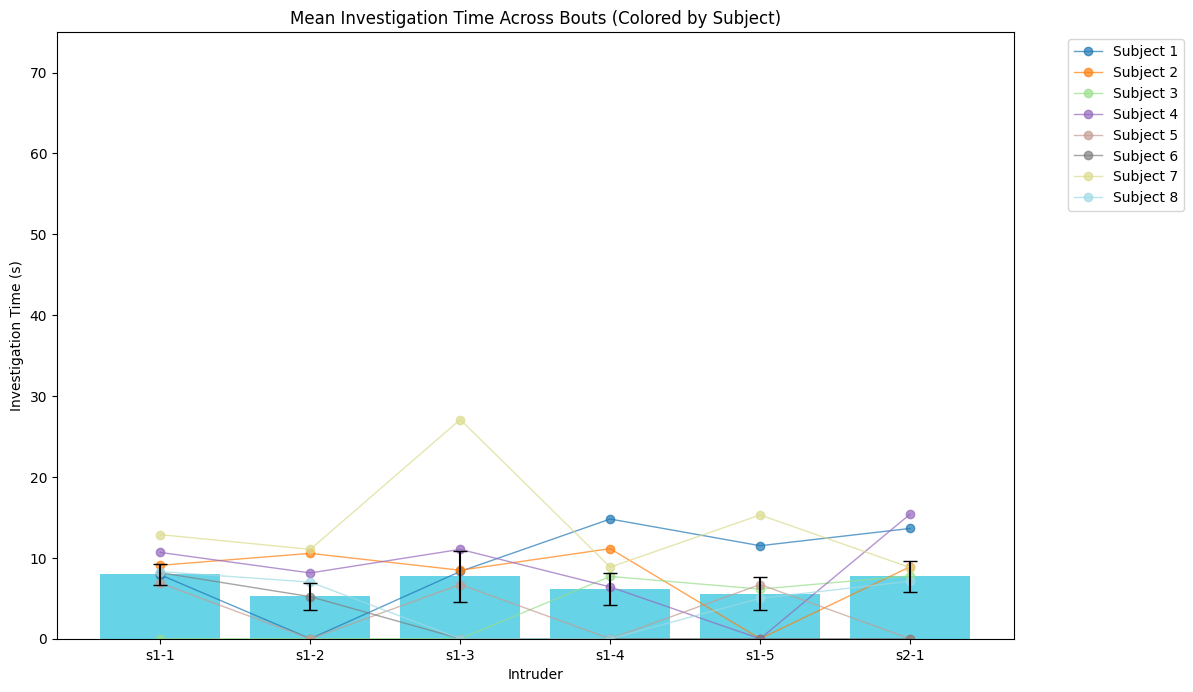

UnboundLocalError: cannot access local variable 'pivot_df' where it is not associated with a value

In [ ]:
def hab_dishab_plot_y_across_bouts_colored(
    df, 
    title='Mean Across Bouts', 
    ylabel='Mean Value', 
    custom_xtick_labels=None, 
    custom_xtick_colors=None, 
    ylim=None, 
    bar_color='#00B7D7',
    yticks_increment=None, 
    xlabel='Intruder',
    figsize=(12,7), 
    pad_inches=1,
    cmap_name='tab10'
):
    """
    Plots the mean values (with SEM error bars) for each bout, plus each subject's data 
    in a unique color. The color map can be customized via `cmap_name` (e.g. 'tab10', 'tab20').
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate means and SEM across subjects
    means = df.mean(axis=0)
    sems = df.sem(axis=0)
    x = np.arange(len(df.columns))

    # Create a color map to get a unique color for each subject
    cmap = plt.cm.get_cmap(cmap_name, len(df.index))

    # -------------------------------------------------------
    # Plot each subject's data in a unique color + label
    # -------------------------------------------------------
    for i, idx in enumerate(df.index):
        subject_color = cmap(i)
        label = f"Subject {idx}"  # <--- ADDED: a label for the legend
        ax.plot(
            x, 
            df.loc[idx, :], 
            color=subject_color, 
            alpha=0.7, 
            marker='o', 
            linewidth=1,
            label=label             # <--- ADDED: pass the label here
        )

    # Bar chart for the means + error bars
    ax.bar(x, means, yerr=sems, color=bar_color, alpha=0.6, capsize=5)

    # Set x-axis ticks/labels
    if custom_xtick_labels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(custom_xtick_labels)
        if custom_xtick_colors is not None:
            for tick_label, c in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick_label.set_color(c)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(df.columns)

    # Labels and title
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Y-axis limit
    if ylim is not None:
        ax.set_ylim(ylim)

    # Custom y-ticks increment
    if yticks_increment is not None:
        start, end = ax.get_ylim()
        ax.set_yticks(np.arange(start, end + yticks_increment, yticks_increment))

    # -------------------------------------------------------
    # ADDED LEGEND: show the subject labels
    # -------------------------------------------------------
    # You can place the legend in many ways. For example, to the right:
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # or simply:
    # ax.legend(loc='best')

    plt.tight_layout(pad=pad_inches)
    plt.show()


# Suppose pivot_df is the DataFrame used in your plot function.
# Fill NaN with 0 for all subjects/bouts.
    pivot_df = pivot_df.fillna(0)

# Now re-plot
hab_dishab_plot_y_across_bouts_colored(
    df=pivot_df,
    title="Mean Investigation Time Across Bouts (Colored by Subject)",
    ylabel="Investigation Time (s)",
    ylim=(0, 75),
    cmap_name='tab20'
)
